In [248]:
# %% import necessary tools
print("import necessary tools")
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pandas as pd
import tqdm as notebook_tqdm

import necessary tools


In [249]:
#%% import data
from sklearn.model_selection import train_test_split
print("import data")
df = pd.read_csv('20230628_Interfacial-Toughness.csv')  
df = df.sample(frac=1)
x = df.iloc[:,1:4]
y = df.loc[:,"Toughness (J/m^2)"]
noises = df.loc[:,"Stdev (J/m^2)"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train))
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test))
#x_train = torch.tensor(np.array(x)[:nTrain,:])
#y_train = torch.tensor(np.array(y)[:nTrain])

#%% pre process data
from sklearn import preprocessing

# scale x training data per standard scaler to N(0,1)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))

# apply log to y training data and then scale to N(0,1)
y_train = torch.log(y_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = torch.tensor(y_scaler.transform(y_train.reshape(-1,1))).squeeze()
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
nTrain = y_train.size(dim=0)
noises_train = torch.tensor(np.array(noises)[:nTrain]) # divide by sqrt(n)
# need to scale noises only by dividing by stdev of inputs
noises_train = noises_train/torch.std(x_train)
print(x_train.size())
print(y_train.size())
print(x_test.size())
print(y_test.size())
print(noises_train.size())
#noise_scaler = preprocessing.StandardScaler().fit(noises_train.reshape(-1,1))
#noises_train = noise_scaler.transform(noises_train.reshape(-1,1))
#noises_train[np.isnan(noises_train)]=np.average(noises_train[np.isnan(noises_train)==False])
#print(noises_train)

import data
torch.Size([77, 3])
torch.Size([77])
torch.Size([20, 3])
torch.Size([20])
torch.Size([77])


In [250]:
#%%
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises_train,learn_additional_noise=True)
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

# need to find way to set prior variance (constant in front of RBF kernel)

In [251]:
# %%
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=200

print('Starting GP parameter tuning...')
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if np.mod(i,20)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale 1: %.3f   lengthscale 2: %.3f   lengthscale 3: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
        ))
        #print('Iter %d/%d - Loss: %.3f %' (
        #    i + 1, training_iter, loss.item()
            #model.covar_module.base_kernel.lengthscale,
            #model.covar_module.base_kernel.lengthscale[1],
            #model.covar_module.base_kernel.lengthscale[2]
        #))
        #torch.print("lengthscale: "+str(model.covar_module.base_kernel.lengthscale))
    optimizer.step()

Starting GP parameter tuning...
Iter 1/200 - Loss: 1.413   lengthscale 1: 0.693   lengthscale 2: 0.693   lengthscale 3: 0.693
Iter 21/200 - Loss: 1.330   lengthscale 1: 2.105   lengthscale 2: 5.580   lengthscale 3: 5.580
Iter 41/200 - Loss: 1.329   lengthscale 1: 2.139   lengthscale 2: 6.882   lengthscale 3: 6.882
Iter 61/200 - Loss: 1.329   lengthscale 1: 1.946   lengthscale 2: 7.304   lengthscale 3: 7.304
Iter 81/200 - Loss: 1.328   lengthscale 1: 1.900   lengthscale 2: 7.553   lengthscale 3: 7.553
Iter 101/200 - Loss: 1.328   lengthscale 1: 1.890   lengthscale 2: 7.765   lengthscale 3: 7.765
Iter 121/200 - Loss: 1.328   lengthscale 1: 1.884   lengthscale 2: 7.960   lengthscale 3: 7.960
Iter 141/200 - Loss: 1.328   lengthscale 1: 1.880   lengthscale 2: 8.141   lengthscale 3: 8.141
Iter 161/200 - Loss: 1.328   lengthscale 1: 1.880   lengthscale 2: 8.308   lengthscale 3: 8.308
Iter 181/200 - Loss: 1.328   lengthscale 1: 1.879   lengthscale 2: 8.462   lengthscale 3: 8.462


In [252]:
x_test = torch.tensor(np.array(x)[nTrain:,:])
x_test = torch.tensor(scaler.transform(x_test))
y_test = torch.log(torch.tensor(np.array(y)[nTrain:]))
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
#print(y_test)

model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_test))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)

# scaling back input/output data
y_test_inverse = y_scaler.inverse_transform(y_test.reshape(-1,1))
x_test_inverse = scaler.inverse_transform(x_test)
predictive_mean_inverse = y_scaler.inverse_transform(predictive_mean.reshape(-1,1))

tensor([ 0.6252,  0.1225,  0.5107,  0.6252, -0.2511,  0.5107,  0.1225, -0.6349,
         0.5107,  0.5304, -0.1634, -1.4289, -0.5763, -0.2052,  0.4776,  0.6548,
        -0.6349,  0.1414,  0.4893, -0.5578], dtype=torch.float64)


In [253]:
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)
#corr = np.corrcoef(predictive_mean,y_train)[0,1]
print(f'nTrained model NLPD: {final_nlpd:.2f}')
#print('Mean predictions correlated: '+str(corr))

print(y_test)
print(predictive_mean)
print(lower)
print(upper)

nTrained model NLPD: 1.31
tensor([ 1.7237, -0.4040,  0.1090,  0.5282,  1.5230, -0.2169, -0.4602, -0.2250,
         0.9765, -0.3189,  0.0990, -4.3422,  0.0063,  0.7754,  0.5902,  1.0622,
        -0.4567, -0.0920,  0.7267, -0.4548], dtype=torch.float64)
tensor([ 0.6252,  0.1225,  0.5107,  0.6252, -0.2511,  0.5107,  0.1225, -0.6349,
         0.5107,  0.5304, -0.1634, -1.4289, -0.5763, -0.2052,  0.4776,  0.6548,
        -0.6349,  0.1414,  0.4893, -0.5578], dtype=torch.float64)
tensor([-1.0098, -1.4459, -1.0730, -1.0098, -1.8657, -1.0730, -1.4459, -2.1907,
        -1.0730, -1.0489, -1.7295, -3.1377, -2.1232, -1.7567, -1.1142, -0.9244,
        -2.1907, -1.4272, -1.1207, -2.1099], dtype=torch.float64)
tensor([2.2601, 1.6908, 2.0944, 2.2601, 1.3634, 2.0944, 1.6908, 0.9208, 2.0944,
        2.1097, 1.4027, 0.2800, 0.9706, 1.3462, 2.0695, 2.2339, 0.9208, 1.7100,
        2.0994, 0.9942], dtype=torch.float64)


20


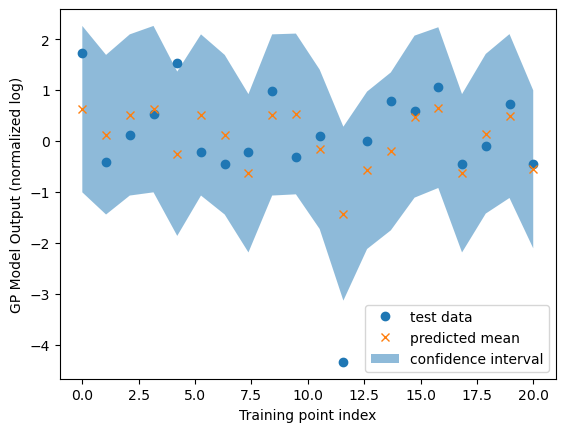

In [254]:
test_size=y_test.size(dim=0)
print(test_size)
testInds = np.linspace(0,int(test_size),num=test_size)
plt.figure()
plt.plot(testInds,y_test,'o',label = 'test data')
plt.plot(testInds,predictive_mean,'x',label='predicted mean')
#plt.plot(testInds,lower,'-',label = 'lower confidence interval')
#plt.plot(testInds,upper,'-',label = 'upper confidence interval')
plt.fill_between(testInds,lower,upper,alpha=0.5, label = 'confidence interval')
plt.xlabel("Training point index")
plt.ylabel("GP Model Output (normalized log)")
plt.legend(loc=4)

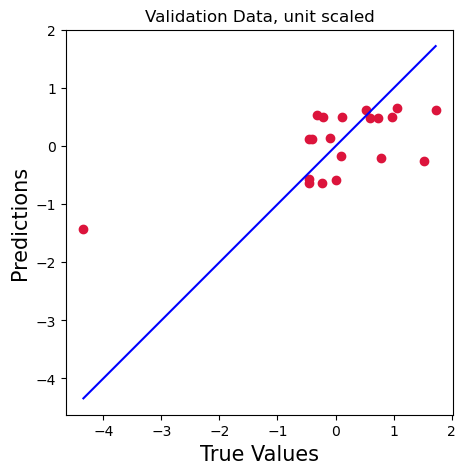

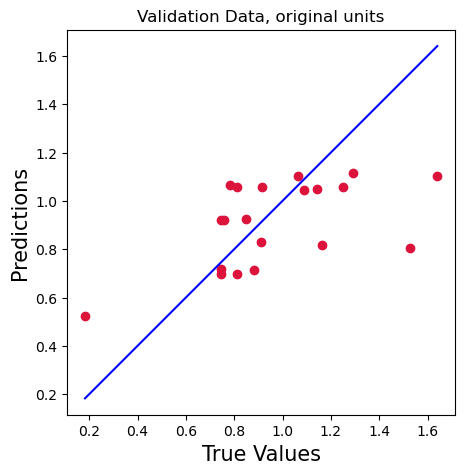

In [255]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, predictive_mean, c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(predictive_mean), max(y_test))
p2 = min(min(predictive_mean), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, unit scaled")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_test_inverse), np.exp(predictive_mean_inverse), c='crimson')
#plt.scatter(y_test, lower, c='blue')
#plt.scatter(y_test, upper, c='green')

p1 = max(max(np.exp(predictive_mean_inverse)), max(np.exp(y_test_inverse)))
p2 = min(min(np.exp(predictive_mean_inverse)), min(np.exp(y_test_inverse)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Validation Data, original units")
plt.show()

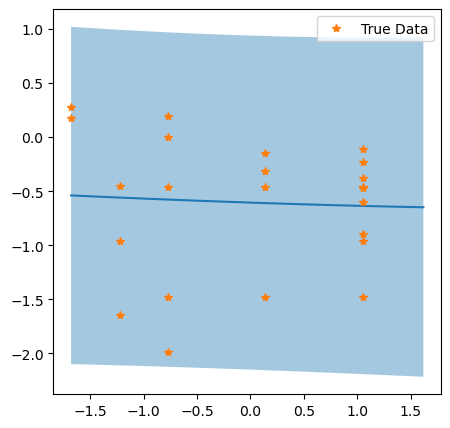

In [259]:
testPress = torch.linspace(0,10,steps=100)
testTime = torch.ones((100,))*15;  testTemp = torch.ones((100,))*150
testInputs = torch.vstack((testTime,testPress,testTemp)).transpose(0,1)
testInputs = torch.tensor(scaler.transform(testInputs))
with torch.no_grad():
    test_trained_pred_dist = likelihood(model(testInputs))
    test_predictive_mean = test_trained_pred_dist.mean
    test_lower, test_upper = test_trained_pred_dist.confidence_region()

plt.figure(figsize=(5,5))
plt.plot(testInputs[:,1],test_predictive_mean)
plt.fill_between(testInputs[:,1],test_lower,test_upper,alpha=.4)
x=np.array(x)
y=np.array(y)
#print(np.logical_and(x[:,0]==15, x[:,2]==150))
#print(y_scaler.transform(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]).reshape(-1,1)))
#print(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]))
trueYs = y_scaler.transform(np.log(y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]).reshape(-1,1))
#trueYs = y[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]
trueXs = scaler.transform(x[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))])[:,1]
#trueXs = x[np.where(np.logical_and(x[:,0]==15, x[:,2]==150))]
plt.plot(trueXs,trueYs,'*',label='True Data')
plt.legend()
#plt.scatter()

# transform to original coordinates correctly, differentiate bt test/training points


In [257]:
x = np.array(x); y=np.array(y)
print(np.where((x[:,0]==15)) and np.where(x[:,2]==150))
print(np.where(np.logical_and(x[:,0]==15, x[:,2]==150)))
print(np.where((x[:,2]==150))  )
print(x[np.where((x[:,0]==15)) and np.where(x[:,2]==150)]) 
print(model.mean_module.constant)
model.covar_module.base_kernel.lengthscale

(array([ 0,  1,  3,  4,  5,  6,  8, 10, 16, 18, 19, 20, 24, 26, 29, 31, 33,
       38, 39, 40, 44, 45, 46, 49, 50, 51, 56, 57, 58, 59, 60, 61, 62, 65,
       67, 74, 76, 78, 83, 84, 87, 89, 90, 93, 94, 96]),)
(array([ 0,  1,  3, 10, 19, 20, 29, 38, 39, 40, 45, 46, 51, 56, 58, 59, 62,
       65, 74, 84, 89, 93, 96]),)
(array([ 0,  1,  3,  4,  5,  6,  8, 10, 16, 18, 19, 20, 24, 26, 29, 31, 33,
       38, 39, 40, 44, 45, 46, 49, 50, 51, 56, 57, 58, 59, 60, 61, 62, 65,
       67, 74, 76, 78, 83, 84, 87, 89, 90, 93, 94, 96]),)
[[ 15.           8.273712   150.        ]
 [ 15.           8.273712   150.        ]
 [ 15.           8.273712   150.        ]
 [  5.           8.273712   150.        ]
 [ 10.           8.273712   150.        ]
 [  5.           8.273712   150.        ]
 [ 10.           0.         150.        ]
 [ 15.           1.378952   150.        ]
 [  0.           0.         150.        ]
 [  5.           2.757904   150.        ]
 [ 15.           2.757904   150.        ]
 [ 15.    

tensor([[1.8792, 8.6043, 0.0108]], grad_fn=<SoftplusBackward0>)